# DS 7331 - Machine Learning - Course Project
Team: Allison Roderick, Jayson Barker, Sandesh Ojha, Brandon Croom

Lab Number: Mini Project

## Model Creation/Parameters - 50pts

### US Focused Model

The code below represent the build out of the logistical regression model for the US Accidents data set for the entire US.

Perfom the initial setup in the three code blocks below. We'll import the necessary libraries required for this analysis. We'll then define helper functions that will be leveraged later in the analysis. Finally we'll import the  EDA that has already been performed. This will allow us to leverage the existing work and prevent duplication. It should be noted that for this specific analysis we have commented out the graphs that were built in the initial EDA. This is simply to assist in speeding up the logistic regression analysis. 

In [32]:
# Import libraries for data analysis
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier

In [2]:
#Define helper functions
def getMedianTemp(row):
    month = row['SM_Interim']
    state = row['State']
    
    try:
        result = medianTempByStateMonth[state,month]
    except:
        result = medianTempByMonth[month]
    finally:    
        return result

def getMedianPrecip(row):
    month = row['SM_Interim']
    state = row['State']
    
    try:
        result = medianPrecipByStateMonth[state,month]
    except:
        result = medianPrecipByMonth[month]
    finally:
        return result

def getMedianPressure(row):
    month = row['SM_Interim']
    state = row['State']
    
    try:
        result = medianPressureByStateMonth[state,month]
    except:
        result = medianPrecipByMonth[month]
    finally:
        return result

def getMedianWindChill(row):
    month = row['SM_Interim']
    state = row['State']
    
    try:
        result = medianWindChillByStateMonth[state,month]
    except:
        result = medianWindChillByMonth[month]
    finally:
        return result

def getMedianVis(row):
    month = row['SM_Interim']
    state = row['State']
    
    try:
        result = medianVisByStateMonth[state,month]
    except:
        result = medianVisByMonth[month]
    finally:
        return result

def getMedianWindSpeed(row):
    month = row['SM_Interim']
    state = row['State']
    
    try:
        result = medianWindSpeedByStateMonth[state,month]
    except:
        result = medianWindSpeedByMonth[month]
    finally:
        return result

def getMedianHumidity(row):
    month = row['SM_Interim']
    state = row['State']
    
    try:
        result = medianHumidityByStateMonth[state,month]
    except:
        result = medianHumidityByMonth[month]
    finally:
        return result

def checkMissingValues(df):
    missing_df = df.isnull().sum(axis=0).reset_index()
    missing_df.columns = ['columns_name','missing_count']
    missing_df['missing_ratio'] = missing_df['missing_count'] /df.shape[0]
    return missing_df.loc[missing_df['missing_ratio']>0.00]

In [3]:
#Run the initial EDA from the first lab for the project. 
#NOTE: We've commented out the graphs and analysis portions from the EDA just to make things run faster, hence the "Skinny"
#version of the filename
%run ./JB_AR_BC_SO_Project1_Skinny.ipynb

Initial Shape:  (2974335, 49)
Deduplication Shape:  (2974335, 49)
No Duplicate Data Found
['MapQuest' 'MapQuest-Bing' 'Bing']
['Calm' 'SW' 'SSW' 'WSW' 'WNW' 'NW' 'West' 'NNW' 'NNE' 'South' 'North'
 'Variable' 'SE' 'SSE' 'ESE' 'East' 'NE' 'ENE' 'E' 'W' nan 'S' 'VAR'
 'CALM' 'N']
['Calm' 'SW' 'SSW' 'WSW' 'WNW' 'NW' 'W' 'NNW' 'NNE' 'S' 'N' 'VAR' 'SE'
 'SSE' 'ESE' 'E' 'NE' 'ENE' nan 'CALM']
['Light Rain' 'Overcast' 'Mostly Cloudy' 'Rain' 'Light Snow' 'Haze'
 'Scattered Clouds' 'Partly Cloudy' 'Clear' 'Snow'
 'Light Freezing Drizzle' 'Light Drizzle' 'Fog' 'Shallow Fog' 'Heavy Rain'
 'Light Freezing Rain' 'Cloudy' 'Drizzle' nan 'Light Rain Showers' 'Mist'
 'Smoke' 'Patches of Fog' 'Light Freezing Fog' 'Light Haze'
 'Light Thunderstorms and Rain' 'Thunderstorms and Rain' 'Fair'
 'Volcanic Ash' 'Blowing Sand' 'Blowing Dust / Windy' 'Widespread Dust'
 'Fair / Windy' 'Rain Showers' 'Mostly Cloudy / Windy'
 'Light Rain / Windy' 'Hail' 'Heavy Drizzle' 'Showers in the Vicinity'
 'Thunderstorm' 'Lig

/home/jbcroom/anaconda3/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Now we'll copy the EDA ready dataframe into a secondary dataframe. This will allow us to get back to initial state if something goes awry.

In [4]:
# Copy the dataframe from the original as we'll be manipulating it for analysis
df2 = df.copy()

Let's determine what our model prediction accuracy should be based on just assigning all accidents "Low Severity." This will give us a benchmark of comparison for our models

In [5]:
# We are searching for a model to predict better than just assigning all accidents "low severity"
# Thus, we need a model prediction accuracy higher than below

print(1994378/(1994378+979957))

0.670529042626335


From the above calculation we can see that we need our model accuray to be greater than 67%. This will give us something to compare against for logistic regression and SVM.

Build out the initial list of features we want to put through the logistic regression model. We'll keep the majority of the features. City, Country, ZipCode and the accident End date values will be removed for this initial pass. We'll also create a temporary column for Start Month and State for assistance with a few future items that need to be addressed with this field. We will also collapse the severity values into two values O for low severity accidents and 1 for high severity accidents.

In [6]:
#Take an initial pass at the features we want to run through logistic regression
featuresList = ['Severity','Start_Lat','Start_Lng','Distance(mi)','Side','Temperature(F)','Wind_Chill(F)',
                'Humidity(%)','Pressure(in)','Visibility(mi)','Wind_Speed(mph)','Precipitation(in)',
                'PointOfInterest','Bump','Crossing','Yield','Junction','No_Exit','Railway',
                'Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal','Turning_Loop','Sunrise_Sunset',
                'Start_Month','Start_Hour','Start_Weekday','Time_Duration(min)','State',
                'Timezone','Start_Time','Weather_Condition_Collapsed','TMC']

#filter down the dataframe to just the features needed
df2 = df2[featuresList]

#duplicate the Start Month. This will help us later
df2['SM_Interim'] = df2['Start_Month']

#duplicate the Start Month. This will help us later
df2['ST'] = df2['State']

# replace severity to binary
df2.Severity.replace([0, 1, 2, 3, 4], [0, 0, 0, 1, 1], inplace=True)

# view recoded variable
df2['Severity'].value_counts() 

0.0    1994178
1.0     979553
Name: Severity, dtype: int64

Clean up missing values in the data set.

In [7]:
#Let's look to see what missing data has been created by the dummy numerics
checkMissingValues(df2)

,columns_name,missing_count,missing_ratio
0,Severity,582,0.000196
1,Start_Lat,582,0.000196
2,Start_Lng,582,0.000196
3,Distance(mi),582,0.000196
4,Side,582,0.000196
5,Temperature(F),56611,0.019033
6,Wind_Chill(F),1852794,0.622932
7,Humidity(%),59721,0.020079
8,Pressure(in),48696,0.016372
9,Visibility(mi),66242,0.022271


In [8]:
cleanList = ['SM_Interim','State','Turning_Loop','Traffic_Signal','Traffic_Calming','Stop','Station',
             'Roundabout','Railway','No_Exit','Junction','Yield','Crossing','Bump','PointOfInterest',
             'Distance(mi)','Start_Lng','Start_Lat','Severity','Timezone','TMC',
             'Weather_Condition_Collapsed','Sunrise_Sunset']

df2.dropna(axis=0,how='any',subset=cleanList,inplace=True)
checkMissingValues(df2)

,columns_name,missing_count,missing_ratio
5,Temperature(F),6665,0.003029
6,Wind_Chill(F),1391570,0.632469
7,Humidity(%),8940,0.004063
8,Pressure(in),2517,0.001144
9,Visibility(mi),5267,0.002394
10,Wind_Speed(mph),301374,0.136974
11,Precipitation(in),1493869,0.678963


From the table above we're left with missing values in weather related data. We'll impute this data after we do our test train split to ensure we properly push the data to the correct areas.

Now let's split our categorical variables into dummy columns for the logistic regression

In [9]:
# transform categories into dummy numerics
cols_to_transform = ['Side','Sunrise_Sunset','Start_Weekday','Start_Month','ST','Weather_Condition_Collapsed','TMC']

df2 = pd.get_dummies(df2, columns = cols_to_transform)

#check to make sure everything transformed
df2.dtypes

Severity          float64
Start_Lat         float64
Start_Lng         float64
Distance(mi)      float64
Temperature(F)    float64
                   ...   
TMC_339.0           uint8
TMC_341.0           uint8
TMC_343.0           uint8
TMC_351.0           uint8
TMC_406.0           uint8
Length: 148, dtype: object

We'll proceed to build out our test and training datasets using an 80/20 split. Since our data is temporal we'll need to break by Start_Time.

In [10]:
df2=df2.sort_values("Start_Time")
#Build the test/train split. Use a split of 80/20
#Get the values for Y
y = df2['Severity'].values

#Delete off the values for Y so they don't get duplicated in the split
del df2['Severity']

#get everything else that we want to predict off of
x = df2.values

train_size = int(len(x) * 0.80)
X_train, X_test = x[0:train_size], x[train_size:len(x)]

y_train, y_test = y[0:train_size], y[train_size:len(x)]

Now that we have our test/train splits convert the numpy arrays back to dataframes while we continue data manipulation

In [11]:
#Convert the train/test splits back to dataframes so we can impute missing data. 
df_X_train = pd.DataFrame.from_records(X_train)
df_X_test = pd.DataFrame.from_records(X_test)
df_X_train.columns = df2.columns
df_X_test.columns = df2.columns

In [12]:
print(df_X_train["Start_Time"].min())
print(df_X_train["Start_Time"].max())
print(df_X_test["Start_Time"].min())
print(df_X_test["Start_Time"].max())

2016-02-08 05:46:00
2019-05-08 07:38:42
2019-05-08 07:38:53
2019-12-31 23:50:02


As shown above, we are splitting the training data from the testing data by using the first 80% of the data, sorted by time, to test on. This equates to approximately 50 months for training and 7 months to test on.

Let's check to make sure we're maintaining a consistent shape between our test and train dataframes. This is more of a sanity check for future items than anyting

In [13]:
#Check the dataframe shapes for sanity
print(df_X_train.shape)
print(df_X_test.shape)

(1760176, 147)
(440044, 147)


Since we know our weather data is what's missing in both the training and test sets let's try to fix it. We'll start by finding the median for each weather value by state and month. This should provide us the most accurate value for imputing the missing value. We'll also calculate the median value by month. This is simply a precaution in the event we can't find a state/month combination. Finally we'll apply these values to the dataframes.

In [14]:
#Given that we're looking at weather based conditions take median values for each of the features. Initially start by
#determining median by state and start month. To also cover any missing values that may not be present with this 
#combination calculate the overall median by month. 
medianTempByStateMonth = df_X_train.groupby(['State','SM_Interim'])['Temperature(F)'].median(skipna=True)
medianPrecipByStateMonth  = df_X_train.groupby(['State','SM_Interim'])['Precipitation(in)'].median(skipna=True)
medianPressureByStateMonth  = df_X_train.groupby(['State','SM_Interim'])['Pressure(in)'].median(skipna=True)
medianWindChillByStateMonth  = df_X_train.groupby(['State','SM_Interim'])['Wind_Chill(F)'].median(skipna=True)
medianVisByStateMonth  = df_X_train.groupby(['State','SM_Interim'])['Visibility(mi)'].median(skipna=True)
medianWindSpeedByStateMonth  = df_X_train.groupby(['State','SM_Interim'])['Wind_Speed(mph)'].median(skipna=True)
medianHumidityByStateMonth  = df_X_train.groupby(['State','SM_Interim'])['Humidity(%)'].median(skipna=True)

medianTempByMonth = df_X_train.groupby(['SM_Interim'])['Temperature(F)'].median(skipna=True)
medianPrecipByMonth  = df_X_train.groupby(['SM_Interim'])['Precipitation(in)'].median(skipna=True)
medianPressureByMonth  = df_X_train.groupby(['SM_Interim'])['Pressure(in)'].median(skipna=True)
medianWindChillByMonth  = df_X_train.groupby(['SM_Interim'])['Wind_Chill(F)'].median(skipna=True)
medianVisByMonth  = df_X_train.groupby(['SM_Interim'])['Visibility(mi)'].median(skipna=True)
medianWindSpeedByMonth  = df_X_train.groupby(['SM_Interim'])['Wind_Speed(mph)'].median(skipna=True)
medianHumidityByMonth  = df_X_train.groupby(['SM_Interim'])['Humidity(%)'].median(skipna=True)

In [15]:
df_X_train.loc[pd.isnull(df_X_train['Temperature(F)']),'Temperature(F)'] = df_X_train.swifter.apply(getMedianTemp, axis=1)
df_X_train.loc[pd.isnull(df_X_train['Precipitation(in)']),'Precipitation(in)'] = df_X_train.swifter.apply(getMedianPrecip,axis=1)
df_X_train.loc[pd.isnull(df_X_train['Pressure(in)']),'Pressure(in)'] = df_X_train.swifter.apply(getMedianPressure,axis=1)
df_X_train.loc[pd.isnull(df_X_train['Wind_Chill(F)']),'Wind_Chill(F)'] = df_X_train.swifter.apply(getMedianWindChill,axis=1)
df_X_train.loc[pd.isnull(df_X_train['Visibility(mi)']),'Visibility(mi)'] = df_X_train.swifter.apply(getMedianVis,axis=1)
df_X_train.loc[pd.isnull(df_X_train['Wind_Speed(mph)']),'Wind_Speed(mph)'] = df_X_train.swifter.apply(getMedianWindSpeed,axis=1)
df_X_train.loc[pd.isnull(df_X_train['Humidity(%)']),'Humidity(%)'] = df_X_train.swifter.apply(getMedianHumidity,axis=1)
    
#if anything else remains we'll zero it out
df_X_train['Precipitation(in)'].fillna(0,inplace=True)
df_X_train['Wind_Chill(F)'].fillna(0,inplace=True)
df_X_train['Wind_Speed(mph)'].fillna(0,inplace=True)
df_X_train['Temperature(F)'].fillna(0,inplace=True)
df_X_train['Precipitation(in)'].fillna(0,inplace=True)
df_X_train['Visibility(mi)'].fillna(0,inplace=True)
df_X_train['Humidity(%)'].fillna(0,inplace=True)

In [16]:
df_X_test.loc[pd.isnull(df_X_test['Temperature(F)']),'Temperature(F)'] = df_X_test.swifter.apply(getMedianTemp, axis=1)
df_X_test.loc[pd.isnull(df_X_test['Precipitation(in)']),'Precipitation(in)'] = df_X_test.swifter.apply(getMedianPrecip,axis=1)
df_X_test.loc[pd.isnull(df_X_test['Pressure(in)']),'Pressure(in)'] = df_X_test.swifter.apply(getMedianPressure,axis=1)
df_X_test.loc[pd.isnull(df_X_test['Wind_Chill(F)']),'Wind_Chill(F)'] = df_X_test.swifter.apply(getMedianWindChill,axis=1)
df_X_test.loc[pd.isnull(df_X_test['Visibility(mi)']),'Visibility(mi)'] = df_X_test.swifter.apply(getMedianVis,axis=1)
df_X_test.loc[pd.isnull(df_X_test['Wind_Speed(mph)']),'Wind_Speed(mph)'] = df_X_test.swifter.apply(getMedianWindSpeed,axis=1)
df_X_test.loc[pd.isnull(df_X_test['Humidity(%)']),'Humidity(%)'] = df_X_test.swifter.apply(getMedianHumidity,axis=1)
    
#if anything else remains we'll zero it out
df_X_test['Precipitation(in)'].fillna(0,inplace=True)
df_X_test['Wind_Chill(F)'].fillna(0,inplace=True)
df_X_test['Wind_Speed(mph)'].fillna(0,inplace=True)
df_X_test['Temperature(F)'].fillna(0,inplace=True)
df_X_test['Precipitation(in)'].fillna(0,inplace=True)
df_X_test['Visibility(mi)'].fillna(0,inplace=True)
df_X_test['Humidity(%)'].fillna(0,inplace=True)

Let's verify that we've imputed all the missing values and now have a clean data set.

In [17]:
#Let's make sure we have everthing accounted for
checkMissingValues(df_X_test)

,columns_name,missing_count,missing_ratio


In [18]:
#Let's make sure we have everthing accounted for
checkMissingValues(df_X_train)

,columns_name,missing_count,missing_ratio


Now that we've confirmed out data is clean. We have one final clean up item to address. We need to remove th SM_Interim column from both dataframes as is duplicative.

In [19]:
#drop the interim columns for Start Month  and State that was used for imputing
df_X_train.drop(['SM_Interim'],axis=1,inplace=True)
df_X_test.drop(['SM_Interim'],axis=1,inplace=True)

df_X_train.drop(['Timezone'],axis=1,inplace=True)
df_X_test.drop(['Timezone'],axis=1,inplace=True)

df_X_train.drop(['State'],axis=1,inplace=True)
df_X_test.drop(['State'],axis=1,inplace=True)

df_X_train.drop(['Start_Time'],axis=1,inplace=True)
df_X_test.drop(['Start_Time'],axis=1,inplace=True)

Check to make sure our dataframes are shaped the same.

In [20]:
#Check the dataframe shapes for sanity
print(df_X_train.shape)
print(df_X_test.shape)

(1760176, 143)
(440044, 143)


In [21]:
#convert our test/train dataframes to numpy arrays
X_train = df_X_train.to_numpy()
X_test = df_X_test.to_numpy()

Execute out logistic regression analysis on the data.

In [50]:
# logistic regression
%time
logistic_regression= LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='liblinear')
logistic_regression.fit(X_train,y_train)
y_pred=logistic_regression.predict(X_test)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs


In [23]:
# Accuracy | Accuracy = (TP+TN)/Total
print(mt.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.83      0.82    309416
         1.0       0.57      0.54      0.55    130628

    accuracy                           0.74    440044
   macro avg       0.69      0.68      0.69    440044
weighted avg       0.74      0.74      0.74    440044



Based on the accurracy calculation we're at 74% accuracy with this model. This is higher than our worst case scenario of 67% initially calculated. Below we'll visually represent the confusion matrix above.

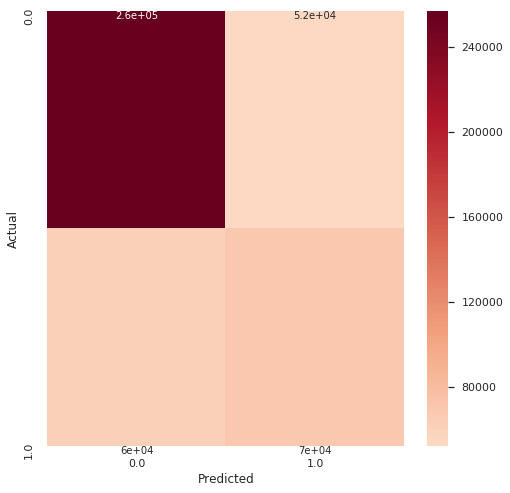

In [24]:
# Confusion matrix

fig, ax = plt.subplots(figsize=(8, 8))

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])


annot_kws = {"ha": 'center',"va": 'top'}
ax = sns.heatmap(confusion_matrix, annot=True, annot_kws=annot_kws, cmap ='RdBu_r', center=0)

Now let's determine what the logistic regression coefficients look like

In [25]:
#Coefficients
weights = logistic_regression.coef_.T # take transpose to make a column vector
variable_names = df2.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])

Start_Lat has weight of -0.050836047716004716
Start_Lng has weight of 0.015438555842302368
Distance(mi) has weight of 0.20366084209989124
Temperature(F) has weight of 0.0012907069692894933
Wind_Chill(F) has weight of -0.0003991723171144219
Humidity(%) has weight of -0.002042896474221387
Pressure(in) has weight of 0.11271273393530087
Visibility(mi) has weight of -0.0028331212901687914
Wind_Speed(mph) has weight of 0.005050410811337742
Precipitation(in) has weight of 0.09469190393696361
PointOfInterest has weight of -1.3464964909490562
Bump has weight of -0.1277402451301119
Crossing has weight of -0.9453597551384139
Yield has weight of 0.3542176781828267
Junction has weight of 0.5552744659083063
No_Exit has weight of 0.10816945570239331
Railway has weight of 0.4649976734439463
Roundabout has weight of -0.16012537290337886
Station has weight of -0.7757724698720527
Stop has weight of -2.390763345584338
Traffic_Calming has weight of -0.29557836189362635
Traffic_Signal has weight of -1.52318

The table above lists the non-normalized coefficients for the model. We'll normalize them next to make it more interpretable

In [26]:
#NOTE: Code below adapted from the course lectures
# we want to normalize the features based upon the mean and standard deviation of each column. 

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set 

# train the model just as before
lr_clf = LogisticRegression(penalty='l2', C=0.05, solver='liblinear') 
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set predictions

The accuracy of the scaled model has not changed.

In [27]:
print(mt.classification_report(y_test,y_hat))

              precision    recall  f1-score   support

         0.0       0.81      0.83      0.82    309416
         1.0       0.57      0.54      0.55    130628

    accuracy                           0.74    440044
   macro avg       0.69      0.68      0.69    440044
weighted avg       0.74      0.74      0.74    440044



The table below lists the normalized coefficients for the model. We'll interpret these coefficients in the interpretation section below.

In [28]:
# output the coefficients
weights = lr_clf.coef_.T # take transpose to make a column vector
variable_names = df_X_train.columns
zip_vars = zip(weights,variable_names)

for coef, name in zip_vars:
    print(name, 'has weight of', coef[0])

Start_Lat has weight of 0.0030645775211284353
Start_Lng has weight of 1.3300833166462789
Distance(mi) has weight of 0.28947118600983895
Temperature(F) has weight of 0.022546741374188984
Wind_Chill(F) has weight of -0.015326068411069675
Humidity(%) has weight of -0.04432174307734469
Pressure(in) has weight of 0.0430712360375494
Visibility(mi) has weight of -0.007148715987908389
Wind_Speed(mph) has weight of 0.02468523668473469
Precipitation(in) has weight of 0.013863293985950882
PointOfInterest has weight of -0.15379597294360398
Bump has weight of -0.0069250266924642985
Crossing has weight of -0.2670890972848689
Yield has weight of 0.017618784334852255
Junction has weight of 0.12247304765734122
No_Exit has weight of 0.00742489863425348
Railway has weight of 0.04382188844126999
Roundabout has weight of -0.03535160102253797
Station has weight of -0.11286289060014025
Stop has weight of -0.28805150901207766
Traffic_Calming has weight of -0.02228558949836985
Traffic_Signal has weight of -0.6

Let's plot the coefficients of the variables to see which ones have the most pull and which ones we may be able to use to reduce the model.

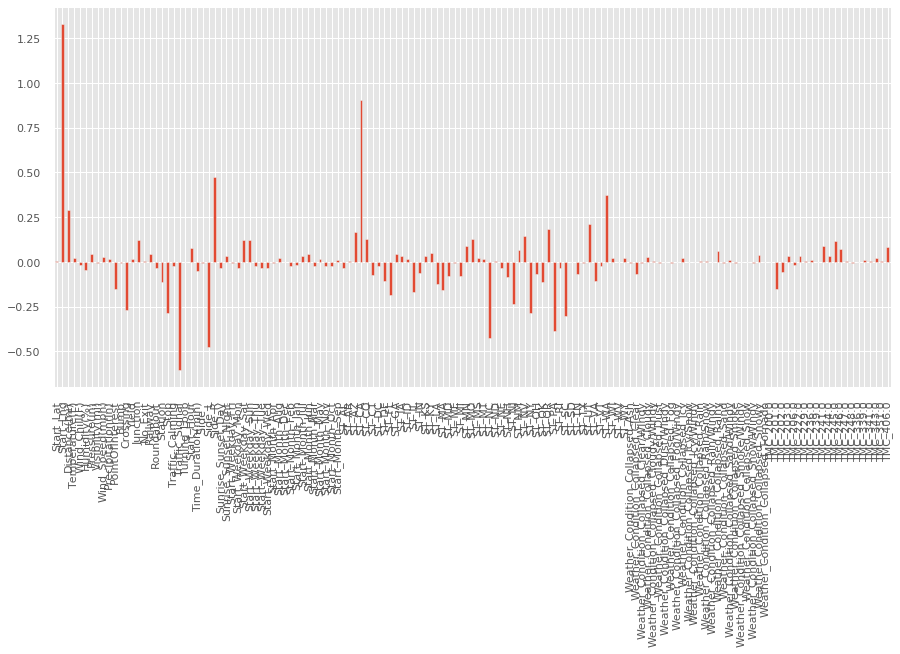

In [29]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(figsize=(15,7))
plt.style.use('ggplot')

variable_names = df_X_train.columns

weights = pd.Series(lr_clf.coef_[0],index=variable_names)
weights.plot(kind='bar')
plt.show()

Looking at the graph it seems coefficients greater than 0.5 and less than -0.25 have the greatest influence. Let's determine what those are and see if just using them helps the model accuracy.

In [30]:
# output the coefficients
coefToKeep = []
weights = lr_clf.coef_.T # take transpose to make a column vector
variable_names = df_X_train.columns
for coef, name in zip(weights,variable_names):
    if coef[0] < -0.25 or coef[0] > 0.50:
        print(name, 'has weight of', coef[0])
        coefToKeep.append(name)

Start_Lng has weight of 1.3300833166462789
Crossing has weight of -0.2670890972848689
Stop has weight of -0.28805150901207766
Traffic_Signal has weight of -0.6027169853688484
Side_L has weight of -0.47474742846242696
ST_CA has weight of 0.9061582462434126
ST_NC has weight of -0.42333267603275565
ST_NY has weight of -0.2850972605691208
ST_PA has weight of -0.3872904685976665
ST_SC has weight of -0.30260170930100516


### SVM Model

Below is the code to run a Support Vector Machine (SVM) model using a stochastic gradient descent (SGD). We decided that using this method would be optimal due to the large number of both features and observations in our dataset.

In [49]:
%%time
regularize_const = 0.1
iterations = 5
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_iter_no_change=iterations, n_jobs=-1, penalty='l2', shuffle=True)

svm_sgd.fit(X_train_scaled,y_train)
yhat = svm_sgd.predict(X_test_scaled)
    
conf = mt.confusion_matrix(y_test,yhat)
acc = mt.accuracy_score(y_test,yhat)

print('SVM:', acc)

SVM: 0.7384375198843752
CPU times: user 11.9 s, sys: 700 ms, total: 12.6 s
Wall time: 8.86 s


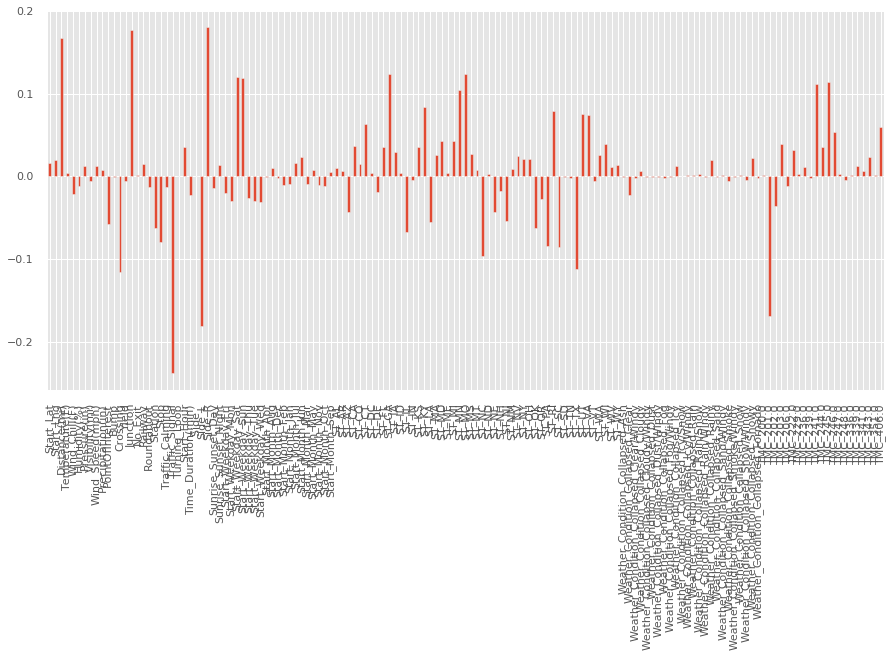

In [42]:
# if using linear kernel, these make sense to look at (not otherwise, why?)
#print(svm_sgd.coef_)
df3 = pd.concat([df_X_train, df_X_test],axis=0)
weights = pd.Series(svm_sgd.coef_[0],index=df3.columns)
fig= plt.figure(figsize=(15,7))
weights.plot(kind='bar')

In [43]:
features = df3.columns.to_numpy()
coefficients = svm_sgd.coef_.T.squeeze()

svm_coef = pd.DataFrame({"Features":features, "Coefficients":coefficients, "Abs Coefficients":np.absolute(coefficients)})
print(svm_coef.sort_values("Abs Coefficients",ascending=False).head(10))

              Features  Coefficients  Abs Coefficients
21      Traffic_Signal     -0.237733          0.237733
26              Side_L     -0.181069          0.181069
27              Side_R      0.181069          0.181069
14            Junction      0.177033          0.177033
123          TMC_201.0     -0.169140          0.169140
2         Distance(mi)      0.167862          0.167862
71               ST_MO      0.123636          0.123636
58               ST_GA      0.123492          0.123492
32   Start_Weekday_Sat      0.120067          0.120067
33   Start_Weekday_Sun      0.118702          0.118702


In [44]:
print(conf)

[[265234  44182]
 [ 70879  59749]]


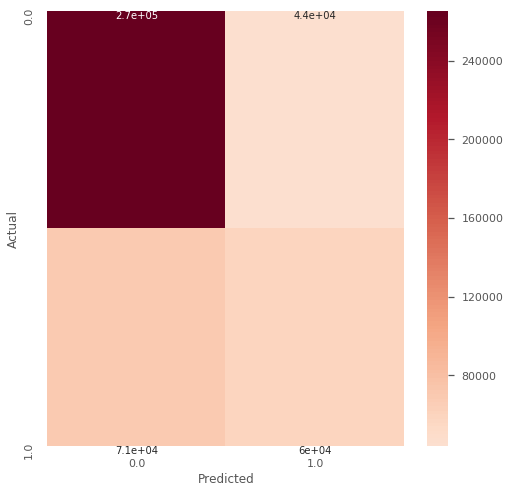

In [45]:
fig, ax = plt.subplots(figsize=(8, 8))

confusion_matrix = pd.crosstab(y_test, yhat, rownames=['Actual'], colnames=['Predicted'])


annot_kws = {"ha": 'center',"va": 'top'}
ax = sns.heatmap(confusion_matrix, annot=True, annot_kws=annot_kws, cmap ='RdBu_r', center=0)

In [46]:
print(mt.classification_report(y_test,yhat))

              precision    recall  f1-score   support

         0.0       0.79      0.86      0.82    309416
         1.0       0.57      0.46      0.51    130628

    accuracy                           0.74    440044
   macro avg       0.68      0.66      0.67    440044
weighted avg       0.73      0.74      0.73    440044



## Model Advantages - 10pts

Looking at the two models we can see that accuracy on both models wes respectively the same at 74%. Based on this alone there isn't a major superiority of one over another. There is a slight edge with the SVM model in training time. This model ran in seconds where as the logistic regression model took minutes to execute. All in all based on the way the data is being looked at there doesn't seem to be a superiority of one model over the other except in training time. As models get more complex this would provide the SVM model an edge as it executes faster. 

## Interpretation - 30pts

The graph below shows all of the coefficient values for the logistic regression model. Given the size of the model we see a good amount of variables that do not have a large influence on the model. Most everything between the -0.25 to 0.25 range have very little input into the overall model.

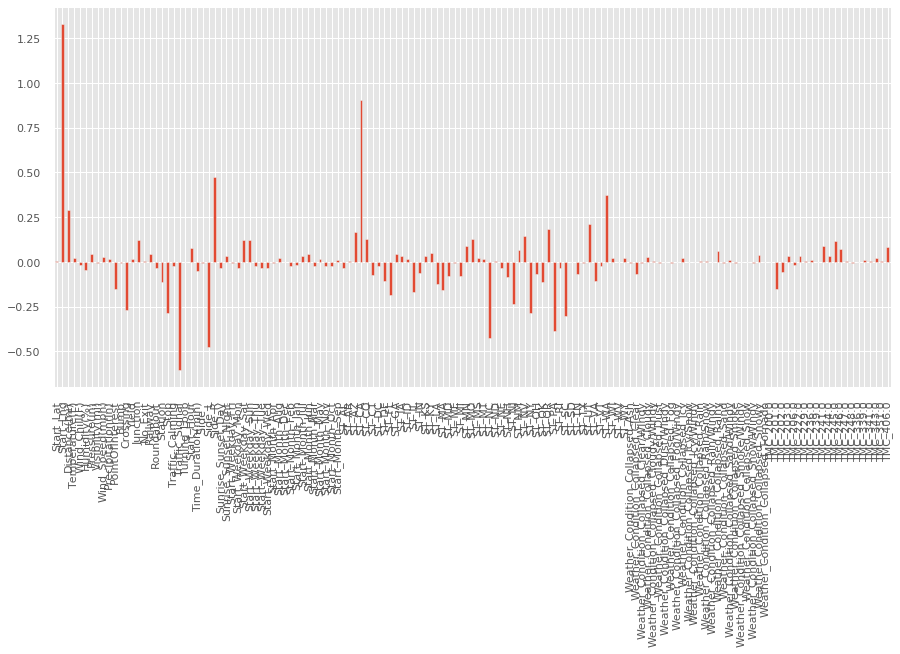

In [51]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(figsize=(15,7))
plt.style.use('ggplot')

variable_names = df_X_train.columns

weights = pd.Series(lr_clf.coef_[0],index=variable_names)
weights.plot(kind='bar')
plt.show()

Let's take a closer look at those coefficients that are outside the -0.25 to 0.25 range. This would provide us with a more detailed view of what is influencing the model. 

In [52]:
# output the coefficients
coefToKeep = []
weights = lr_clf.coef_.T # take transpose to make a column vector
variable_names = df_X_train.columns
for coef, name in zip(weights,variable_names):
    if coef[0] < -0.25 or coef[0] > 0.25:
        print(name, 'has weight of', coef[0])
        coefToKeep.append(name)

Start_Lng has weight of 1.3300833166462789
Distance(mi) has weight of 0.28947118600983895
Crossing has weight of -0.2670890972848689
Stop has weight of -0.28805150901207766
Traffic_Signal has weight of -0.6027169853688484
Side_L has weight of -0.47474742846242696
Side_R has weight of 0.47476070524108355
ST_CA has weight of 0.9061582462434126
ST_NC has weight of -0.42333267603275565
ST_NY has weight of -0.2850972605691208
ST_PA has weight of -0.3872904685976665
ST_SC has weight of -0.30260170930100516
ST_WA has weight of 0.37388037884737224


From the list above of normalized coefficients, we see that we go down to approximately 13 factors that are influencing the model. Details that arise from this are as follows with logical commentary:

- Positive Impacts on Accident Severity:
    - Start_Lng - Location of the accident is key to determining severity
    - Distance - Distance the accident spans could indicate severity. 
    - Side_R - The side of the vehicle the accident occurs is most frequently the right side. 
    - ST_CA - As the most populated state, being in CA would be more prone to accidents
    - ST_WA - Interesting value in that WA is the 13th most populated state
    

- Negative Impacts on Accident Severity:
    - Crossing - being close to a railroad crossing may mean drivers are paying more attention and thus less severe accidents occur
    - Stop - being close to a stop sign may mean drivers are paying more attention and thus less severe accidents occur
    - Traffic_Signal - being close to a traffic signal may mean drivers are paying more attention and thus less severe accidents occur
    - Side_L - An accident that occurs on the left side of the car is likey less severe
    - ST_NC - Less severe accidents occur in NC
    - ST_NY - Less severe accidents occur in NY
    - ST_PA - Less severe accidents occur in PA
    - ST_SC - Less severe accidents occur in SC


## SVM Insight - 10pts

The SVM model performs at an accuracy rate of 74%. As show in the confusion matrix above, we still are fighting the issue of low specificity at only 26%. That is, this model does not correctly identify the high severity accidents well, which is one of our goals in a model.

In this model, we see that the TMC variables are highly important. The TMC variables are codes that specifically describe the type of accident. These codes can be highly important in our final implementation of the model. If first responders can be trained to differentiate between low and high severity accidents based on the code and type of accident, resouces can be more efficiently allocated. Additionally we see that weekend days are important as well. This may also provide a first responder staffind indication.